This experiment focus on modelling specifically with **hot water** as the variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from skforecast.model_selection import select_features

import plotly
import plotly.graph_objects as go


from astral import LocationInfo
from astral.sun import sun


In [2]:
from custom_utils import *

In [3]:
def get_raw_data():
    data_path = "./../data/"
    file_name = "data.csv"
    data = pd.read_csv(data_path + file_name)
    data = first_preprocess(data, data_path)
    return data

In [4]:
data = get_raw_data()
data.head()

d:\RA_work\timeseries_data\notebooks\custom_utils.py:110: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data[column] = data[column].interpolate(method="linear", limit_direction="both")


,space_heating,hot_water,sockets,lighting,bld_engcons,car_chargers,weekend,bank_holiday,day_of_month,year,...,month_spline_9,month_spline_10,month_spline_11,day_of_week_spline_0,day_of_week_spline_1,day_of_week_spline_2,day_of_week_spline_3,day_of_week_spline_4,day_of_week_spline_5,day_of_week_spline_6
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.425193,0.000000,0.049433,0.154873,3.629499,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 01:00:00+00:00,4.012907,0.000000,0.047753,0.154846,4.215506,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 02:00:00+00:00,5.342417,0.444782,0.051869,0.154997,5.994066,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 03:00:00+00:00,5.756598,0.000000,0.043028,0.154626,5.954252,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667
2021-01-01 04:00:00+00:00,5.415492,0.000000,0.050306,0.154498,5.620296,0.0,0,1,1,2021,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.166667,0.666667


In [5]:
data.columns

Index(['space_heating', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'sine_hour', 'cos_hour', 'sine_month', 'cos_month',
       'sine_day_of_week', 'cos_day_of_week', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 'hour_spline_0', 'hour_spline_1',
       'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5',
       'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9',
       'hour_spline_10', 'hour_spline_11', 'hour_spline_12', 'hour_spline_13',
       'hour_spline_14', 'hour_spline_15', 'hour_spline_16', 'hour_spline_17',
       'hour_spline_18', 'hour_spline_19', 'hour_spline_20', 'hour_spline_21',
       'hour_spline_22', 'hour_spline_23', 'mont

In [6]:
exo_columns = ['forecast_temperature', 'forecast_feelslike', 
               'forecast_weathertype',
       # 'forecast_windspeed', 
       'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility', 
       # 'daylight_hours',  
       # 'is_daylight', 
       'sine_hour',
       'cos_hour', 
       'sine_month', 'cos_month', 
       'sine_day_of_week', 'cos_day_of_week', 
       'sine_forecast_winddirection',
       'cos_forecast_winddirection', 
       # 'sine_sunrise_hour', 'cos_sunrise_hour', 'sine_sunset_hour', 'cos_sunset_hour'
       "week_of_year",
       'hour_spline_0', 'hour_spline_1',
       'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5',
       'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9',
       'hour_spline_10', 'hour_spline_11', 'hour_spline_12', 'hour_spline_13',
       'hour_spline_14', 'hour_spline_15', 'hour_spline_16', 'hour_spline_17',
       'hour_spline_18', 'hour_spline_19', 'hour_spline_20', 'hour_spline_21',
       'hour_spline_22', 'hour_spline_23', 'month_spline_0', 'month_spline_1',
       'month_spline_2', 'month_spline_3', 'month_spline_4', 'month_spline_5',
       'month_spline_6', 'month_spline_7', 'month_spline_8', 'month_spline_9',
       'month_spline_10', 'month_spline_11', 'day_of_week_spline_0',
       'day_of_week_spline_1', 'day_of_week_spline_2', 'day_of_week_spline_3',
       'day_of_week_spline_4', 'day_of_week_spline_5', 'day_of_week_spline_6'
       ]
endo_columns = ['weekend',] # "month", "day_of_week" ] # 'bank_holiday'] # 'day_of_month', 'year']
target_column = ["y"]
column_name = exo_columns + endo_columns  + target_column # + ["space_heating"]
test_date = '2023-01-01'

# transform the data
sh_data = data.copy()
sh_data = sh_data.rename(columns={"hot_water": "y"})
# sh_data["y"] = sh_data["space_heating"].shift(-1)
# sh_data = sh_data.dropna(axis=0)
sh_data_scaler, sh_transformed_data = create_std_scaler(sh_data, column_name[:-1])
sh_target_scaler, sh_transformed_target_data = create_std_scaler(sh_data, column_name[-1])

sh_transformed_data = pd.merge(sh_transformed_data, sh_transformed_target_data,
                              left_index=True,
                              right_index=True)

# Training and testing data for comms and services
sh_train_data = sh_transformed_data[sh_transformed_data.index < test_date][column_name]
sh_test_data = sh_transformed_data[sh_transformed_data.index >= test_date][column_name]
sh_train_data.shape, sh_test_data.shape


# adding baseline minimum of y

# sh_data.loc[sh_data["y"] <= 0, "y"] = sh_data[sh_data["y"] > 0]["y"].min()

# sh_train_data = sh_data[sh_data.index < test_date][column_name]
# sh_test_data = sh_data[sh_data.index >= test_date][column_name]

                              columns          mean    variance  scale_factor
0                forecast_temperature  1.184456e+01   21.642635      4.652165
1                  forecast_feelslike  9.344768e+00   29.482598      5.429788
2                forecast_weathertype  6.297584e+00   23.407858      4.838167
3                    forecast_uvindex  1.080594e+00    2.562323      1.600726
4   forecast_precipitationprobability  1.954772e+01  732.843040     27.071074
5                 forecast_visibility  4.683942e+00    0.689986      0.830654
6                           sine_hour -1.845302e-17    0.500000      0.707107
7                            cos_hour -5.549425e-17    0.500000      0.707107
8                          sine_month -5.381100e-03    0.497916      0.705632
9                           cos_month -2.372672e-03    0.502049      0.708554
10                   sine_day_of_week -1.604346e-03    0.500054      0.707145
11                    cos_day_of_week  1.279424e-03    0.499942 

((17520, 60), (8760, 60))

Text(0.5, 1.0, 'Hot water distribution')

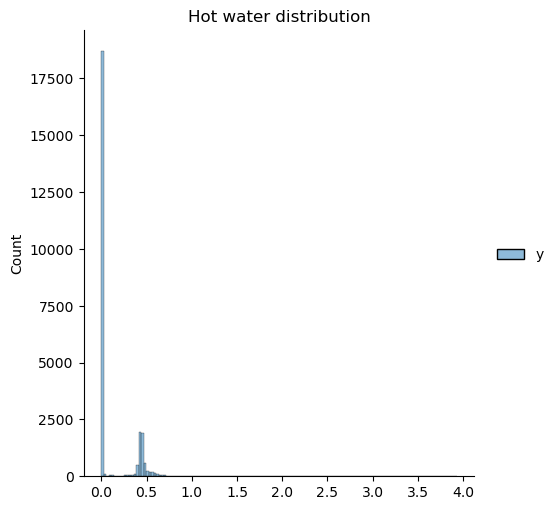

In [7]:
sns.displot(data=sh_data[["y"]])
plt.title("Hot water distribution")

(array([18628., 18748., 18871., 18993., 19113., 19236., 19358., 19478.,
        19601., 19723.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01')])

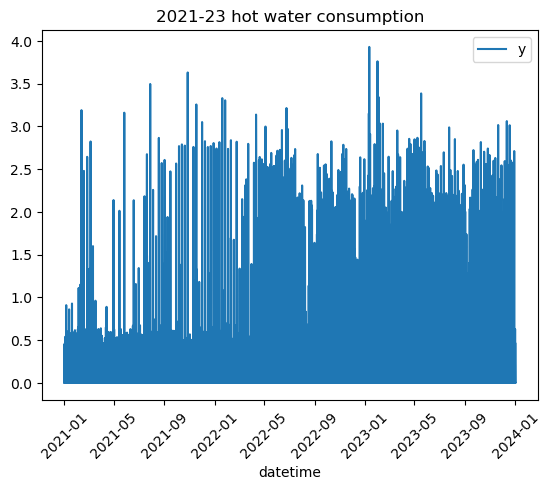

In [8]:
sns.lineplot(data=sh_data[["y"]])
plt.title("2021-23 hot water consumption")
plt.xticks(rotation=45)

In [9]:
def get_year_split(df, year, col_name):
    df = df[[col_name]]
    df.loc[:, "year"] = df.index.year
    year_df = df[df["year"] == year]
    year_df = year_df.rename(columns={f"{col_name}": f"{col_name}_{year}"})
    year_df.loc[:, "time"] = year_df.index.time
    year_df.loc[:, "month"] = year_df.index.month
    year_df.loc[:, "day"] = year_df.index.day

    year_df = year_df.drop(columns="year")
    return year_df

In [10]:
import warnings; warnings.filterwarnings("ignore")
from datetime import datetime

In [11]:
for col in ["hot_water"]:
    year_2021 = get_year_split(data, 2021, col).reset_index(drop=1)
    year_2022 = get_year_split(data, 2022, col).reset_index(drop=1)
    year_2023 = get_year_split(data, 2023, col).reset_index(drop=1)

    common_cols = ["time", "day", "month"]
    tmp1 = year_2021.merge(year_2022, on=common_cols, how="left").merge(year_2023, on=common_cols, how="left")

    def get_key_time(row):
        return datetime(
            year=2000,
            day=row["day"],
            month=row["month"],
            second=row["time"].second,
            hour=row["time"].hour,
            minute=row["time"].minute
        )
    
    tmp1.loc[:, "keytime"] = tmp1.apply(get_key_time, axis=1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2021"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2021'))
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2022"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2022'))
    fig.add_trace(go.Scatter(x=tmp1["keytime"].to_numpy(), y=tmp1[f"{col}_2023"].to_numpy(),
                        mode='lines+markers',
                        name=f'{col}_2023'))

    fig.update_layout(title_text=f"Year on Year data in {col}")
    fig.show()

In [ ]:
def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    return calculate_smape(actual=y_true, predicted=y_pred)

In [ ]:
main_data = pd.concat([sh_train_data, sh_test_data], axis=0)
main_data.shape

In [ ]:
def plot_predictions(plot_data, title_text):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["y"].to_numpy(),
                        mode='lines+markers',
                        name='actual'))
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["pred"].to_numpy(),
                        mode='lines+markers',
                        name='predictions'))
    fig.update_layout(title_text=title_text)
    fig.show()

In [ ]:
from sklearn.linear_model import PoissonRegressor

In [ ]:
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(n_estimators=1000, criterion="squared_error", max_depth=5, max_features="sqrt"),
    # regressor=LinearRegression(),
    lags=2
)

# forecaster = ForecasterAutoreg(
#     regressor=PoissonRegressor(),
#     lags=1
# )

# feature selection
regressor = LGBMRegressor(n_estimators=1000, max_depth=5, random_state=15926, verbose=-1)
selector = RFECV(
    estimator=regressor, step=1, cv=5, min_features_to_select=10, n_jobs=-1
)
selected_autoreg, selected_exog = select_features(
   forecaster         = forecaster,
   selector           = selector,
   select_only        = "exog", 
   y                  = sh_train_data['y'],
   exog               = sh_train_data[exo_columns + endo_columns],
   subsample          = 0.5,
   verbose            = True
)

In [ ]:
forecaster.fit(
    y=sh_train_data['y'],
    exog=sh_train_data[selected_exog]
)

In [ ]:
metric, predictions_training = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = sh_train_data['y'],
    exog               = sh_train_data[selected_exog],
    steps              = 1,
    metric             = "mean_squared_error",
    refit              = False,
    n_jobs             = "auto",
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
predictions_training.head()

In [ ]:
predictions_training["y"] = sh_train_data["y"]
predictions_training = predictions_training.reset_index(drop=0)
predictions_training = predictions_training.rename(columns={"index": "time"})
predictions_training[["pred", "y"]] = sh_target_scaler.inverse_transform(predictions_training[["pred", "y"]])
# predictions_training["pred"] = np.expm1(predictions_training["pred"])
# predictions_training["y"] = np.expm1(predictions_training["y"])
predictions_training.head()

In [ ]:
plot_predictions(predictions_training, title_text="Hot water Training data")

In [ ]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = main_data['y'],
    exog               = main_data[exo_columns + endo_columns],
    steps              = 1,
    metric             = "mean_squared_error",
    initial_train_size = main_data[main_data.index <= test_date].shape[0],
    refit              = 1000,
    fixed_train_size   = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
predictions.head()

In [ ]:
predictions["y"] = main_data[main_data.index >= "2023-01-01"]["y"]
predictions = predictions.reset_index(drop=0)
predictions = predictions.rename(columns={"index": "time"})
predictions[["pred", "y"]] = sh_target_scaler.inverse_transform(predictions[["pred", "y"]])

# neg_pred_pred = predictions[predictions["pred"] < 0]
# predictions.loc[predictions["pred"] <= 0.1, 'pred'] = predictions[predictions["y"] < 0.5]["y"].median()
plot_predictions(predictions, title_text="Hot water Testing data: actual vs predictions")

In [ ]:
cal_metrics(predictions_training["pred"].to_numpy(), predictions_training["y"].to_numpy())

In [ ]:
cal_metrics(predictions["pred"].to_numpy(), predictions["y"].to_numpy())

In [ ]:
tmp_data = pd.concat([predictions_training, predictions], axis=0)
tmp_data = tmp_data.drop(columns=["y"], axis=1)
# tmp_data1 = main_data[main_data.index < '2021-01-01 06:00:00+00:00'][["y"]].reset_index(drop=0)
tmp_data = tmp_data.rename(columns={"y": "pred", "datetime": "time"})
# tmp_data = pd.concat([tmp_data1, tmp_data], axis=0)
tmp_data = tmp_data.set_index("time")
tmp_data = tmp_data.rename(columns={"pred": "hw_predictions"})

tmp_data.to_csv("hotwater_pred.csv", index=True)
tmp_data.shape